# sequence prediction sandbox


In [1]:
import torch
from torch import nn

from collections import defaultdict
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
def kmers(k):
    return [''.join(x) for x in product(['A','C','G','T'], repeat=k)]

def count_kmers_in_seq(seq, mers):
    '''
    For a given sequence and kmer set, return the count
    '''
    return [seq.count(mer) for mer in mers]

seqs8 = kmers(8)
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [3]:
# if you want to down select
seqs8_200 = u.downselect_list(seqs8,200)

In [4]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}

def mode0(seq):
    '''Ignore motifs, just return average score'''
    return np.mean([score_dict[base] for base in seq])

def mode1(seq):
    '''Return average score, TAT gets +10, GCG gets -10'''
    score = np.mean([score_dict[base] for base in seq])
    if 'TAT' in seq:
        score += 10
    if 'GCG' in seq:
        score -= 10
        
    return score

def mode2(seq):
    '''Return average score, GCG gets +10, TAT gets -10'''
    score = np.mean([score_dict[base] for base in seq])
    if 'GCG' in seq:
        score += 10
    if 'TAT' in seq:
        score -= 10
        
    return score
    

modes = {
    0: mode0,
    1: mode1,
    2: mode2,
}
                  
def score_seqs_multi(seqs, mode_list):
    '''
    Mode 0: ignore motifs
    Mode 1: TAT is high, GCG is low
    Mode 2: GCG is high, TAT is low
    '''
    data = []
    for seq in seqs:
        scores = []
        for mode in mode_list:
            score = modes[mode](seq) # call the mode function
            scores.append(score)
        data.append([seq]+scores)
    
    cols = ['seq'] + [f"mode{m}" for m in mode_list]
        
    df = pd.DataFrame(data, columns=cols)
    return df


In [5]:
multi_df = score_seqs_multi(seqs8,[0,1,2])

In [6]:
multi_df[multi_df['seq']=='AATATAAA']

,seq,mode0,mode1,mode2
3264,AATATAAA,17.75,27.75,7.75


In [7]:
multi_df[multi_df['seq']=='AAGCGATA']

,seq,mode0,mode1,mode2
2444,AAGCGATA,17.0,7.0,27.0


In [8]:
multi_df.head()

,seq,mode0,mode1,mode2
0,AAAAAAAA,20.000,20.000,20.000
1,AAAAAAAC,19.625,19.625,19.625
2,AAAAAAAG,19.250,19.250,19.250
3,AAAAAAAT,18.875,18.875,18.875
4,AAAAAACA,19.625,19.625,19.625


### Define some Custom Dataset/Dataloader functions

In [9]:
from torch.utils.data import TensorDataset,DataLoader,Dataset
import random
random.seed(7)

In [10]:
class MultiTaskDatasetOHE(Dataset):
    '''
    Multi-task for one-hot-encoded sequences
    '''
    def __init__(self,df):
        self.seqs = list(df['seq'])
        self.seq_len = len(self.seqs[0])
    
        self.label0 = list(df['mode0'])
        self.label1 = list(df['mode1'])
        self.label2 = list(df['mode2'])
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        seq = torch.tensor(u.one_hot_encode(self.seqs[idx]))
        
        label0 = torch.tensor(float(self.label0[idx]))
        label1 = torch.tensor(float(self.label1[idx]))
        label2 = torch.tensor(float(self.label2[idx]))
        
        return seq, (label0, label1, label2)

    
class MultiTaskDatasetKmer(Dataset):
    '''
    Multi-task for k-mer frequencies
    '''
    def __init__(self,df,k):
        self.seqs = list(df['seq'])
        self.seq_len = len(self.seqs[0])
        self.kmers = kmers(k)
    
        self.label0 = list(df['mode0'])
        self.label1 = list(df['mode1'])
        self.label2 = list(df['mode2'])
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        kmer_vec = torch.tensor(count_kmers_in_seq(self.seqs[idx],self.kmers))
        
        label0 = torch.tensor(float(self.label0[idx]))
        label1 = torch.tensor(float(self.label1[idx]))
        label2 = torch.tensor(float(self.label2[idx]))
        
        return kmer_vec, (label0, label1, label2)

In [11]:
def quick_load_and_split_input(df, split_frac=0.8, verbose=False):
    '''
    Given a df, randomly split between
    train and test. Not a formal train/test split, just a quick n dirty version.
    '''

    # train test split
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split df and convert to tensors
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df, test_df


class DatasetSpec():
    '''
    Quick access class for speciying the type of dataset to build
    '''
    def __init__(self,ds_type,k=None):
        self.name = ds_type
        self.k = k
        
        self.id = self.name if not k else f"{self.name}_{k}"
    

def build_dataloaders(df,ds_types,batch_size=32):
    '''
    Given an input dataframe and a list of dataset types, assemble them into 
    a dictionary of DataLoaders
    '''
    # train test split
    train_df, test_df = quick_load_and_split_input(df)
    
    dls = {} # collect data loaders
    
    # figure out which DataSetTypes needed
    for ds_type in ds_types:
        # Kmer data set
        if ds_type.name == 'multi_kmer':
            if not ds_type.k:
                raise ValueError(f"To use multi_kmer Dataset, you must specify an integer value for k in DatasetSpec")
            assert(type(ds_type.k) == int)

            train_ds = MultiTaskDatasetKmer(train_df,ds_type.k)
            test_ds = MultiTaskDatasetKmer(test_df,ds_type.k)

        # One-hot encoded dataset
        elif ds_type.name == 'multi_ohe':
            train_ds = MultiTaskDatasetOHE(train_df)
            test_ds = MultiTaskDatasetOHE(test_df)

        # unknown datatype?
        else:
            raise ValueError(f"Unknown Dataset Type {ds_type}.")
        
        # Put DataSets into DataLoaders
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
        dls[ds_type.id] = (train_dl,test_dl)
    
    return train_df,test_df, dls

In [12]:
dataset_types = [
    DatasetSpec('multi_ohe'),
    DatasetSpec('multi_kmer',k=1),
    DatasetSpec('multi_kmer',k=3),
    DatasetSpec('multi_kmer',k=6),
]

train_df, test_df, dls = build_dataloaders(multi_df,dataset_types)
dls

{'multi_ohe': (<torch.utils.data.dataloader.DataLoader at 0x7f156f85cdc0>,
  <torch.utils.data.dataloader.DataLoader at 0x7f156f85ce80>),
 'multi_kmer_1': (<torch.utils.data.dataloader.DataLoader at 0x7f156f85cbe0>,
  <torch.utils.data.dataloader.DataLoader at 0x7f1574b20e80>),
 'multi_kmer_3': (<torch.utils.data.dataloader.DataLoader at 0x7f1574b1f3d0>,
  <torch.utils.data.dataloader.DataLoader at 0x7f15746dc1c0>),
 'multi_kmer_6': (<torch.utils.data.dataloader.DataLoader at 0x7f15746dc7c0>,
  <torch.utils.data.dataloader.DataLoader at 0x7f15746dc9a0>)}

In [13]:
dls['multi_kmer_1'][0].dataset.kmers

['A', 'C', 'G', 'T']

### Define Loss and FIt functions

In [14]:
def get_loss_for_condition_average(train_df, test_df, conditions, loss_func):
    '''
    For any sequence, just predict the average of all the training sequences
    scores in that condition. (Basically a column average of that condition in 
    the training set). Since it's not learning over time, this will just be 
    a flat score. Calculate the loss between the actual test set target values
    and this average value. Use this loss as a reference for other models' losses
    over time.
    '''
    # get average score by condition from train df
    losses = []
    for cond in conditions:
        # average from train df
        pred = np.mean(train_df[cond].values)
        
        # target vec from test df
        target_vec = torch.tensor(test_df[cond].values)
        pred_vec = torch.tensor([pred for x in target_vec])
        
        cond_loss = loss_func(pred_vec, target_vec)
        losses.append(cond_loss)
    
    # combine losses from each condition
    loss = torch.mean(torch.stack(losses))
    
    
    return loss.item()
    

In [15]:
# just get loss from predicting average (should be not good cuz not learning anything)
conds = ['mode0','mode1','mode2']
loss_func = torch.nn.MSELoss()
ave_pd_loss = get_loss_for_condition_average(train_df, test_df, conds, loss_func)
ave_pd_loss

13.100788400308923

In [16]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    #print("in Loss Batch...")
    obj0_target = yb[0].unsqueeze(1).float()
    obj1_target = yb[1].unsqueeze(1).float()
    obj2_target = yb[2].unsqueeze(1).float()
    # need unsqueeze otherwise dimension mismatch? [32] vs [32,1]

    
    #loss = loss_func(model(xb.float()), yb.float())
    # yb is a list of tensors... what should it be?
    # how to adapt loss for multi-task?
    #print("yb[0]:", yb[0])
    
    # try looping through ybs?
    res = model(xb.float()) # get predictions? returns list
    
    loss_obj0 = loss_func(res[0], obj0_target)
    loss_obj1 = loss_func(res[1], obj1_target)
    loss_obj2 = loss_func(res[2], obj2_target)
    
    #loss = sum([loss_obj0, loss_obj1, loss_obj2])/3
    loss = torch.mean(torch.stack([loss_obj0, loss_obj1, loss_obj2]))
#     print("what is 'loss'?:")
#     print("0:",loss_obj0)
#     print("1:",loss_obj1)
#     print("2:",loss_obj2)
#     print("all:",loss)
#     print("*****")

    if opt is not None:
        opt.zero_grad() # order? should this be first? last?
        loss.backward()
        opt.step()
        

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, test_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        print('Epoch:',epoch)
        #print("TRAIN")
        model.train()
        ts = []
        ns = []
        # collect train loss; provide opt so backpropo happens
        for xb, yb in train_dl:
            t, n = loss_batch(model, loss_func, xb, yb, opt)
            ts.append(t)
            ns.append(n)
        train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
        train_losses.append(train_loss)
        
        #print("EVAL")
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                # loop through test batches
                # returns loss calc for test set batch size
                # unzips into two lists
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
                # Note: no opt provided, backprop won't happen
            )
        # Gets average MSE loss across all batches (may be of diff sizes, hence the multiply)
        #print("losses", losses)
        #print("nums", nums)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

## Define model types

In [17]:
class DNA_Linear_Multi(nn.Module):
    def __init__(self,seq_len,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin_share = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True)
        )
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(h2_size,1)
        self.obj1  = nn.Linear(h2_size,1)
        self.obj2  = nn.Linear(h2_size,1)
        
        
    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin_share(xb)
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        
        return (out0, out1, out2)

class Kmer_Linear_Multi(nn.Module):
    def __init__(self,num_kmers,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin_share = nn.Sequential(
            nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True)
        )
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(h2_size,1)
        self.obj1  = nn.Linear(h2_size,1)
        self.obj2  = nn.Linear(h2_size,1)
        
        
    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin_share(xb)
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        
        return (out0, out1, out2)
    
    
DATASET_TYPES = {
    'multi_ohe':MultiTaskDatasetOHE,
    'multi_kmer':MultiTaskDatasetKmer,
}
    

## try linear kmer model

Epoch: 0


/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


0 11.856751999405414
Epoch: 1
1 4.682002230173646
Epoch: 2
2 0.3426032183480983
Epoch: 3
3 0.2744198477792056
Epoch: 4
4 0.2580300077436754
Epoch: 5
5 0.25147108303944005
Epoch: 6
6 0.2456342771281038
Epoch: 7
7 0.24188199193695167
Epoch: 8
8 0.2389209546855866
Epoch: 9
9 0.23737343439140587


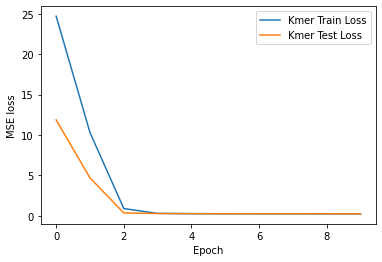

In [18]:
h1 = 10
h2 = 10
train_dl,test_dl = dls['multi_kmer_3']

num_kmers = len(train_dl.dataset.kmers)

kmer_lin_model = Kmer_Linear_Multi(num_kmers, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(kmer_lin_model.parameters(), lr=0.001) 

epochs = 10
train_losses, val_losses = fit(epochs, kmer_lin_model, loss_func, optimizer, train_dl, test_dl)

kmer_lin_data_label = list(zip([train_losses,val_losses], ['Kmer Train Loss','Kmer Test Loss']))
u.quick_loss_plot(kmer_lin_data_label)

In [19]:
# check out model??
kmer_lin_model

Kmer_Linear_Multi(
  (lin_share): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU(inplace=True)
  )
  (obj0): Linear(in_features=10, out_features=1, bias=True)
  (obj1): Linear(in_features=10, out_features=1, bias=True)
  (obj2): Linear(in_features=10, out_features=1, bias=True)
)

In [20]:
lin = kmer_lin_model.lin_share[0]
w = lin.weight
x = sum(w)

xdf = pd.DataFrame(list(zip(train_dl.dataset.kmers, [y.item() for y in x])), columns=['mer','w'])
xdf.sort_values('w').tail(30)

,mer,w
23,CCT,0.211845
16,CAA,0.216238
22,CCG,0.238631
17,CAC,0.253345
40,GGA,0.269545
46,GTG,0.274106
56,TGA,0.282787
48,TAA,0.285408
32,GAA,0.287545
61,TTC,0.317488


### k=1

Epoch: 0
0 9.21463547736579
Epoch: 1
1 9.139394641104435
Epoch: 2
2 8.876683064048379
Epoch: 3
3 8.853804767586524
Epoch: 4
4 8.878353102890355
Epoch: 5
5 8.837328506309083
Epoch: 6
6 8.864650751055105
Epoch: 7
7 8.824267575971447
Epoch: 8
8 8.965333120830909
Epoch: 9
9 8.849924199858343


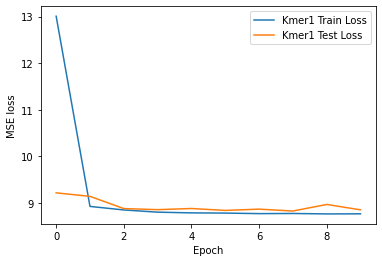

In [21]:
train_dl,test_dl = dls['multi_kmer_1']

num_kmers = len(train_dl.dataset.kmers)

kmer1_lin_model = Kmer_Linear_Multi(num_kmers, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(kmer1_lin_model.parameters(), lr=0.001) 

epochs = 10
train_losses, val_losses = fit(epochs, kmer1_lin_model, loss_func, optimizer, train_dl, test_dl)

kmer1_lin_data_label = list(zip([train_losses,val_losses], ['Kmer1 Train Loss','Kmer1 Test Loss']))
u.quick_loss_plot(kmer1_lin_data_label)

### k=6

Epoch: 0
0 12.871628274414137
Epoch: 1
1 12.634990466888773
Epoch: 2
2 12.419810066071815
Epoch: 3
3 12.184372272730092
Epoch: 4
4 12.000531635016685
Epoch: 5
5 11.884442659278523
Epoch: 6
6 11.827062289599132
Epoch: 7
7 11.801910747723642
Epoch: 8
8 11.771343021811893
Epoch: 9
9 11.725116459087223


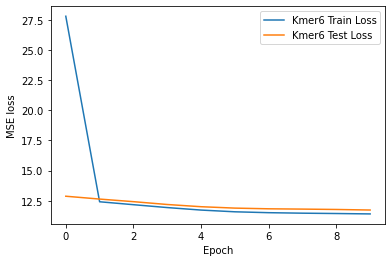

In [22]:
train_dl,test_dl = dls['multi_kmer_6']

num_kmers = len(train_dl.dataset.kmers)

kmer6_lin_model = Kmer_Linear_Multi(num_kmers, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(kmer6_lin_model.parameters(), lr=0.001) 

epochs = 10
train_losses, val_losses = fit(epochs, kmer6_lin_model, loss_func, optimizer, train_dl, test_dl)

kmer6_lin_data_label = list(zip([train_losses,val_losses], ['Kmer6 Train Loss','Kmer6 Test Loss']))
u.quick_loss_plot(kmer6_lin_data_label)

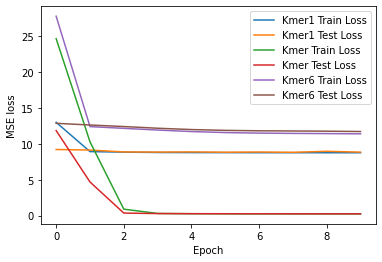

In [23]:
u.quick_loss_plot(kmer1_lin_data_label+kmer_lin_data_label+kmer6_lin_data_label)

## try linear OHE model

In [24]:
h1 = 10
h2 = 10
seq_len = len(train_df['seq'][0])
seq_len

8

Epoch: 0
0 11.637329993831482
Epoch: 1
1 11.07266777304567
Epoch: 2
2 8.794563658978833
Epoch: 3
3 8.70377472402266
Epoch: 4
4 8.63551701908618
Epoch: 5
5 8.484937907356587
Epoch: 6
6 8.268493514108993
Epoch: 7
7 7.877069726454473
Epoch: 8
8 7.521306872695257
Epoch: 9
9 7.12581078657698


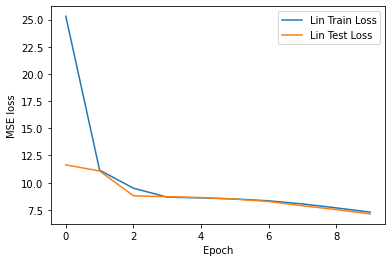

In [25]:
multi_lin_model = DNA_Linear_Multi(seq_len, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_lin_model.parameters(), lr=0.001) 

epochs = 10
train_dl,test_dl = dls['multi_ohe']
train_losses, val_losses = fit(epochs, multi_lin_model, loss_func, optimizer, train_dl, test_dl)

multi_lin_data_label = list(zip([train_losses,val_losses], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(multi_lin_data_label)

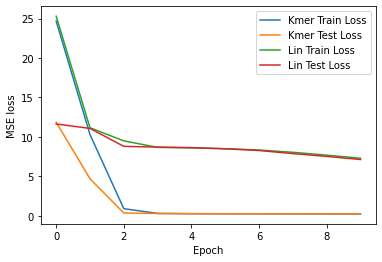

In [26]:
u.quick_loss_plot(kmer_lin_data_label + multi_lin_data_label)

In [49]:
def quick_seq_pred_multi(model, seqs,dss,oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        if dss.name == "multi_ohe":
            s = torch.tensor(u.one_hot_encode(dna))
        elif dss.name == "multi_kmer":
            s = torch.tensor(count_kmers_in_seq(dna,kmers(dss.k)))
        else:
            raise ValueError(f"Unknown DataSetSpec Type {dss.name}. Currently just [multi_ohe,multi_kmer]")
        pred = [x.item() for x in model(s.float())]
        actual = oracle[dna]
        diff = [actual[i]-pred[i] for i in range(len(pred))]
        print(f"{dna}: \n \tpred:{pred[0]:.3f} act:{actual[0]:.3f} ({diff[0]:.3f}) \n\tpred:{pred[1]:.3f} act:{actual[1]:.3f} ({diff[1]:.3f}) \n\tpred:{pred[2]:.3f} act:{actual[2]:.3f} ({diff[2]:.3f})")
        

def quick_test8(model,dss,oracle):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        quick_seq_pred_multi(model, seqs,dss,oracle)
        print()

In [35]:
multi_8mer_oracle['AAAAAAAA']

[20.0, 20.0, 20.0]

In [36]:
multi_8mer_oracle = dict([(x,[a,b,c]) for (x,a,b,c) in multi_df[['seq','mode0','mode1','mode2']].values])

In [47]:
dataset_types

In [50]:
quick_test8(multi_lin_model,DatasetSpec('multi_ohe'),multi_8mer_oracle)

AAAAAAAA: 
 	pred:20.071 act:20.000 (-0.071) 
	pred:20.862 act:20.000 (-0.862) 
	pred:19.367 act:20.000 (0.633)
CCCCCCCC: 
 	pred:16.932 act:17.000 (0.068) 
	pred:14.698 act:17.000 (2.302) 
	pred:19.191 act:17.000 (-2.191)
GGGGGGGG: 
 	pred:14.441 act:14.000 (-0.441) 
	pred:8.852 act:14.000 (5.148) 
	pred:20.014 act:14.000 (-6.014)
TTTTTTTT: 
 	pred:11.164 act:11.000 (-0.164) 
	pred:15.546 act:11.000 (-4.546) 
	pred:6.750 act:11.000 (4.250)

AACCAACA: 
 	pred:18.867 act:18.875 (0.008) 
	pred:18.088 act:18.875 (0.787) 
	pred:19.727 act:18.875 (-0.852)
CCGGCGCG: 
 	pred:15.738 act:15.500 (-0.238) 
	pred:9.695 act:5.500 (-4.195) 
	pred:21.773 act:25.500 (3.727)
GGGTAAGG: 
 	pred:15.108 act:15.125 (0.017) 
	pred:15.881 act:15.125 (-0.756) 
	pred:14.272 act:15.125 (0.853)
TTTCGTTT: 
 	pred:12.203 act:12.125 (-0.078) 
	pred:13.283 act:12.125 (-1.158) 
	pred:11.072 act:12.125 (1.053)
TGTAATAC: 
 	pred:15.547 act:15.500 (-0.047) 
	pred:19.531 act:15.500 (-4.031) 
	pred:11.607 act:15.500 (3.893

In [51]:
quick_test8(kmer_lin_model,DatasetSpec('multi_kmer',k=3),multi_8mer_oracle)

AAAAAAAA: 
 	pred:16.157 act:20.000 (3.843) 
	pred:16.199 act:20.000 (3.801) 
	pred:16.140 act:20.000 (3.860)
CCCCCCCC: 
 	pred:15.036 act:17.000 (1.964) 
	pred:14.976 act:17.000 (2.024) 
	pred:14.911 act:17.000 (2.089)
GGGGGGGG: 
 	pred:13.847 act:14.000 (0.153) 
	pred:13.816 act:14.000 (0.184) 
	pred:13.790 act:14.000 (0.210)
TTTTTTTT: 
 	pred:12.710 act:11.000 (-1.710) 
	pred:12.717 act:11.000 (-1.717) 
	pred:12.597 act:11.000 (-1.597)

AACCAACA: 
 	pred:18.473 act:18.875 (0.402) 
	pred:18.501 act:18.875 (0.374) 
	pred:18.509 act:18.875 (0.366)
CCGGCGCG: 
 	pred:15.152 act:15.500 (0.348) 
	pred:5.196 act:5.500 (0.304) 
	pred:25.159 act:25.500 (0.341)
GGGTAAGG: 
 	pred:15.586 act:15.125 (-0.461) 
	pred:15.578 act:15.125 (-0.453) 
	pred:15.589 act:15.125 (-0.464)
TTTCGTTT: 
 	pred:12.701 act:12.125 (-0.576) 
	pred:12.713 act:12.125 (-0.588) 
	pred:12.676 act:12.125 (-0.551)
TGTAATAC: 
 	pred:15.626 act:15.500 (-0.126) 
	pred:15.560 act:15.500 (-0.060) 
	pred:15.541 act:15.500 (-0.041)

### Try CNN??

In [52]:
class DNA_CNN_Multi(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3,
                 lin_share_size=10
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_share = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), lin_share_size),
            nn.ReLU(inplace=True),
        ) 
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(lin_share_size,1)
        self.obj1  = nn.Linear(lin_share_size,1)
        self.obj2  = nn.Linear(lin_share_size,1)
        
        
    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        
        out = self.conv_share(xb)
        
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        
        return (out0, out1, out2)
        # ^^ where does this go and what does it do?

Epoch: 0
0 1.5467936814213294
Epoch: 1
1 0.3430308430050072
Epoch: 2
2 0.19471219111191887
Epoch: 3
3 0.2737959587504888
Epoch: 4
4 0.1557804974166038
Epoch: 5
5 0.0730900638164122
Epoch: 6
6 0.11788466558437868
Epoch: 7
7 0.0801666717013463
Epoch: 8
8 0.043540415360041246
Epoch: 9
9 0.018220804856512052


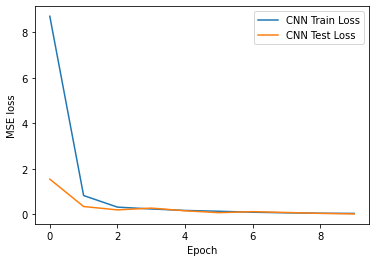

In [62]:
seq_len = len(train_df['seq'][0])
multi_cnn_model = DNA_CNN_Multi(seq_len)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_cnn_model.parameters(), lr=0.01) 

epochs = 10
train_dl,test_dl = dls['multi_ohe']
train_losses_cnn, val_losses_cnn = fit(epochs, multi_cnn_model, loss_func, optimizer, train_dl, test_dl)

multi_cnn_data_label = list(zip([train_losses_cnn,val_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(multi_cnn_data_label)

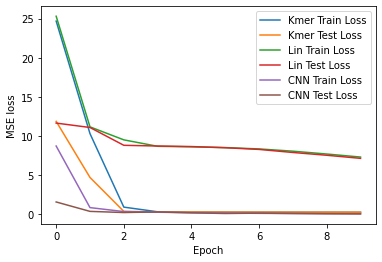

In [63]:
u.quick_loss_plot(kmer_lin_data_label + multi_lin_data_label + multi_cnn_data_label)

In [55]:
quick_test8(multi_cnn_model, DatasetSpec('multi_ohe'), multi_8mer_oracle)

AAAAAAAA: 
 	pred:19.945 act:20.000 (0.055) 
	pred:18.777 act:20.000 (1.223) 
	pred:21.158 act:20.000 (-1.158)
CCCCCCCC: 
 	pred:16.835 act:17.000 (0.165) 
	pred:15.844 act:17.000 (1.156) 
	pred:17.862 act:17.000 (-0.862)
GGGGGGGG: 
 	pred:13.910 act:14.000 (0.090) 
	pred:13.335 act:14.000 (0.665) 
	pred:14.514 act:14.000 (-0.514)
TTTTTTTT: 
 	pred:10.877 act:11.000 (0.123) 
	pred:11.000 act:11.000 (-0.000) 
	pred:10.707 act:11.000 (0.293)

AACCAACA: 
 	pred:18.918 act:18.875 (-0.043) 
	pred:18.243 act:18.875 (0.632) 
	pred:19.616 act:18.875 (-0.741)
CCGGCGCG: 
 	pred:15.911 act:15.500 (-0.411) 
	pred:0.935 act:5.500 (4.565) 
	pred:30.816 act:25.500 (-5.316)
GGGTAAGG: 
 	pred:15.136 act:15.125 (-0.011) 
	pred:15.102 act:15.125 (0.023) 
	pred:15.127 act:15.125 (-0.002)
TTTCGTTT: 
 	pred:12.066 act:12.125 (0.059) 
	pred:11.666 act:12.125 (0.459) 
	pred:12.440 act:12.125 (-0.315)
TGTAATAC: 
 	pred:15.491 act:15.500 (0.009) 
	pred:15.800 act:15.500 (-0.300) 
	pred:15.183 act:15.500 (0.317)

# inspect

### cnn model

In [56]:
multi_cnn_model

DNA_CNN_Multi(
  (conv_share): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=192, out_features=10, bias=True)
    (4): ReLU(inplace=True)
  )
  (obj0): Linear(in_features=10, out_features=1, bias=True)
  (obj1): Linear(in_features=10, out_features=1, bias=True)
  (obj2): Linear(in_features=10, out_features=1, bias=True)
)

In [57]:
conv_layers, model_weights, bias_weights = u.get_conv_layers_from_model(multi_cnn_model)

Total convolutional layers: 1


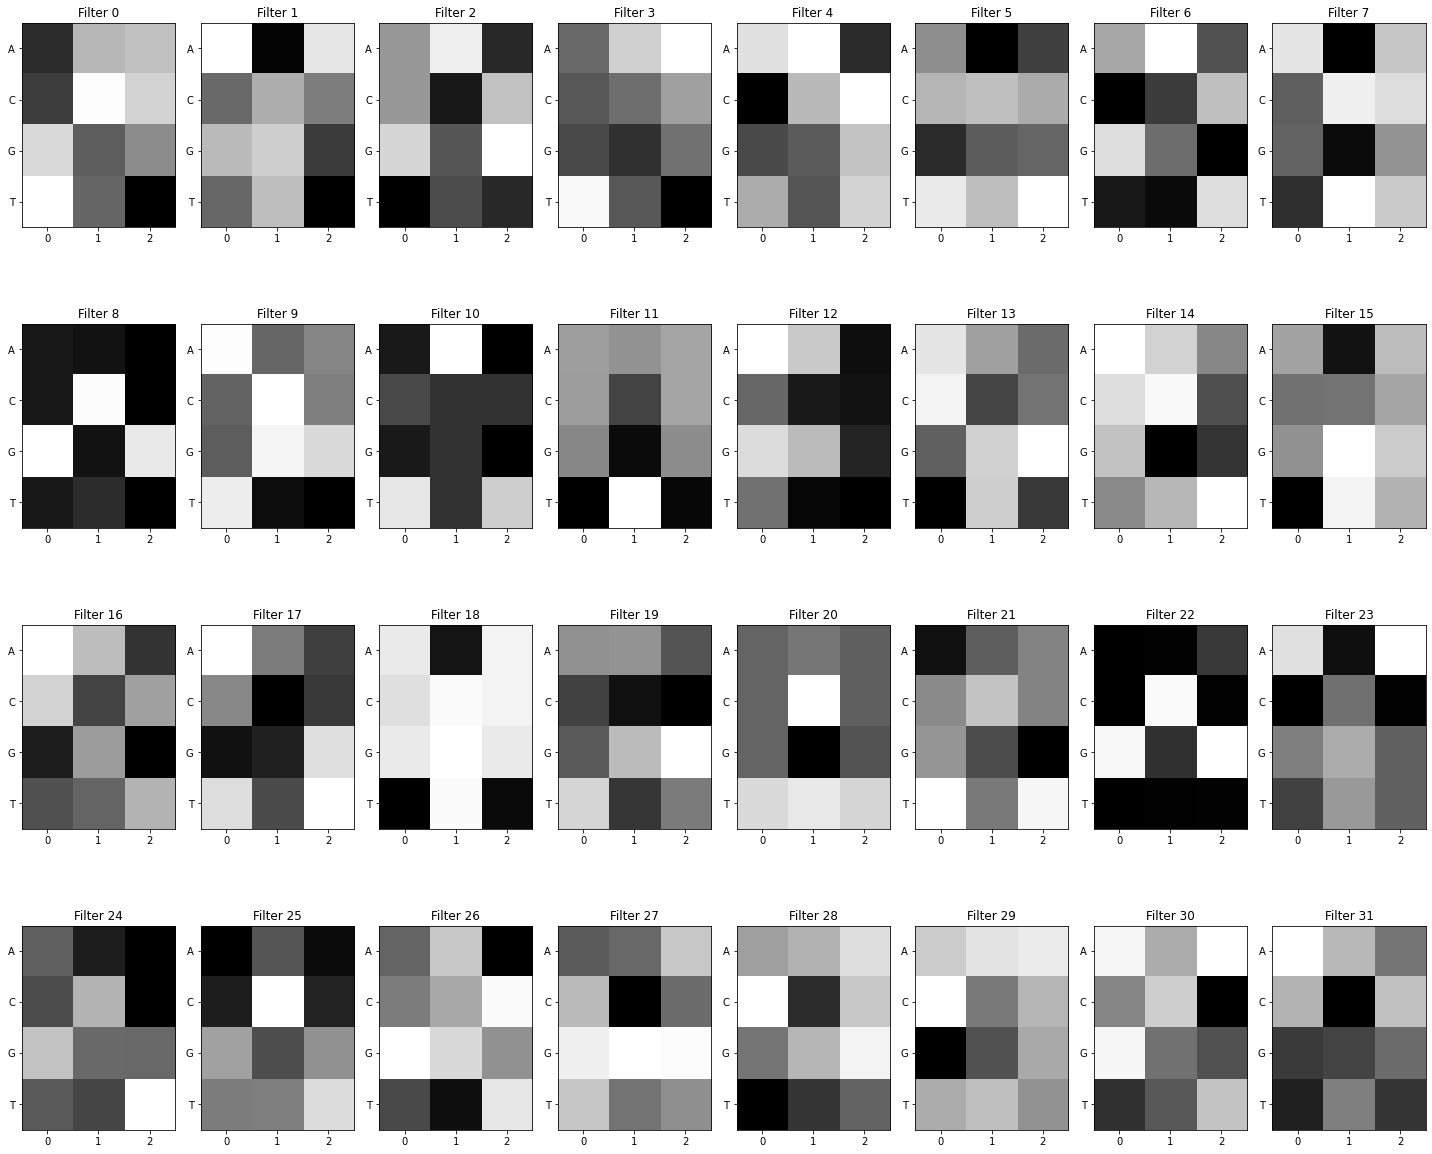

In [58]:
u.view_filters(model_weights)

In [59]:
seqs8_5k = u.downselect_list(seqs8,5000)
filter_activations = u.get_filter_activations(seqs8_5k, conv_layers[0])

Running seq ACCCGGAG
Running seq GGTTGCCA
Running seq CGAGCGTG
Running seq CTAGGCCG
Running seq CCGTCATC
Running seq CGCGGGTT
Running seq CGTGCAGA
Running seq GATCTCAC
Running seq AGCTGATC
Running seq CGTTCCGG
Running seq TCAGGATG
Running seq GGTCATCT
Running seq AGTCAGAT
Running seq TACCGACG
Running seq AGTGGATG
Running seq AGGTAATC
Running seq TATCATGG
Running seq AAATAACT
Running seq AAGGGGGG
Running seq AGTGTATG
Running seq CCATTTAC
Running seq CTTAAAGT
Running seq TGTGCCCT
Running seq CCAGCCTC
Running seq GCAGCATT
Running seq CTATTTAG
Running seq GCGGCTGA
Running seq TTTCATGA
Running seq CAGTCCGT
Running seq CCGCTAGC
Running seq ACCCTACT
Running seq AAGGCCCA
Running seq GTGTCGGG
Running seq AATCATTA
Running seq ATTTGGGT
Running seq AGCCGTTA
Running seq GACCGAGA
Running seq CAAACGCA
Running seq GGTAAGGA
Running seq ATGTGCTA
Running seq TATTATGT
Running seq GAAGATGG
Running seq TTGAAGTC
Running seq GTAAAGCT
Running seq ATACTGGG
Running seq AGTGTAAA
Running seq CCTGTGCC
Running seq A

Running seq CGATTGAT
Running seq TCGTACTA
Running seq ATATCCAG
Running seq GCGTCCAC
Running seq GGATGCCA
Running seq ATGTACAA
Running seq CAGGTCGG
Running seq TGGTCACC
Running seq TTTACGTT
Running seq AGCTATGC
Running seq TATTCGTT
Running seq GTGCCCTT
Running seq TCGGGTGT
Running seq CGGTCCAT
Running seq AGTCCGGG
Running seq GGTAGCCC
Running seq ACCACGTA
Running seq AAAGTCTC
Running seq GTAACCCA
Running seq TTTGTGCG
Running seq ATGCTATT
Running seq GTCTCCAC
Running seq GGCGCATC
Running seq TCACGGGA
Running seq ACATATCC
Running seq CACGGGGT
Running seq TCTTGGCG
Running seq ACTATAAA
Running seq GTGGCACG
Running seq GTAATTAA
Running seq CCTGTCAG
Running seq CCCATTTA
Running seq CACTCGTC
Running seq CGAGCCCA
Running seq CTAGGCGA
Running seq CGATACCC
Running seq TCAAACCA
Running seq GGCAGGTC
Running seq AAATCGGG
Running seq ACACGCGT
Running seq CATCCGAG
Running seq CTAGTGAT
Running seq CGACACTC
Running seq TTCTTCCG
Running seq GATTGTCA
Running seq TCCCTGTC
Running seq GGTAGGGT
Running seq G

Running seq AAACTACG
Running seq TGAGCCAG
Running seq TCGTCTCA
Running seq CATTGCTA
Running seq CCAATATA
Running seq CTACGTCA
Running seq TTTCCGTG
Running seq GGAGGAAA
Running seq GGGACGTT
Running seq TATATCCT
Running seq AATTAGCT
Running seq GTGGATAA
Running seq CACACACT
Running seq AATGGATG
Running seq GACGTATT
Running seq CGCTTGGC
Running seq ATCGAGCT
Running seq GCTTAAGG
Running seq GGCTACTG
Running seq ACCTATCA
Running seq CTATAGGG
Running seq GTTCTCAT
Running seq CATACTAG
Running seq CCCCTGTA
Running seq GCCTCCAT
Running seq CGGACCCA
Running seq GTACAAGA
Running seq CCGTTCCG
Running seq CAGTGTAG
Running seq GCCTGTCG
Running seq TCCAAGAA
Running seq GCTCACAA
Running seq TCAACCTT
Running seq GCAGTTGA
Running seq TTTTACTC
Running seq GTTGGAAA
Running seq GACACTTC
Running seq CGTGAAAC
Running seq GCTTGCAA
Running seq TTTCGCCT
Running seq AGTCGTTT
Running seq ATTCCTTT
Running seq CAATAATC
Running seq CATAAGAC
Running seq CAATCCGG
Running seq ATCAGCAT
Running seq CTTTACTG
Running seq A

Running seq TAATCTAC
Running seq AGGAACCT
Running seq CTAAGACG
Running seq CCAGGGGC
Running seq CATTGGTA
Running seq GGACCTCT
Running seq CACGACCT
Running seq CCCATGAA
Running seq CTTAATTG
Running seq CTCAGCCT
Running seq CACGTTCC
Running seq CCTGGCCG
Running seq TCAACCCA
Running seq ACGGAAAC
Running seq CAACATGA
Running seq TGGTGCCA
Running seq ATACATGA
Running seq TAATCGAT
Running seq AGAAGAGA
Running seq TGGAACTG
Running seq TATTCGCG
Running seq ATTCCAAT
Running seq CGCCGTTG
Running seq CATGGCAA
Running seq CTACGAGC
Running seq TAGAGCGT
Running seq ATACGTCG
Running seq TTGCGAGC
Running seq TATGATAT
Running seq GTCGCGGG
Running seq GCTCTACC
Running seq ACTCAGTA
Running seq AGTTGGTG
Running seq TGGTGCGG
Running seq GACGTATG
Running seq AGCGTAAC
Running seq CTTAACTT
Running seq CGCATGTA
Running seq ACCATGGG
Running seq ATGCCGCA
Running seq TCCATTTT
Running seq ACCGCCCT
Running seq GCTGTCGC
Running seq GGAGCTGG
Running seq CGGGGTAT
Running seq CGGCGACG
Running seq CATATGTA
Running seq T

Running seq CAAAGCGT
Running seq TCAGTGGT
Running seq TCCCCCTA
Running seq CATGGTTG
Running seq AGCCCCAA
Running seq CGATCCAA
Running seq AGTACGAG
Running seq TTAGTGTA
Running seq CTGCGTGC
Running seq CCTCCGAA
Running seq GTTATGTG
Running seq CTTATCTG
Running seq AGCATTCT
Running seq CAATGGCT
Running seq AGGTCATT
Running seq GGAAAGCA
Running seq AACGGGGG
Running seq TGCTGGGA
Running seq CCTATCTG
Running seq ACCGTACT
Running seq CCAATTAG
Running seq CGCTCGCT
Running seq ATATGCAA
Running seq GCGATATA
Running seq GTGACGGA
Running seq GAAAGGTG
Running seq TCGGCAAT
Running seq GTTAGCTT
Running seq CGCCTGTA
Running seq CCTGTTGC
Running seq TCTCGCTT
Running seq TCCAACAT
Running seq GCTTGCTC
Running seq TTAACTAG
Running seq TAACAGAT
Running seq GAGCAGCG
Running seq CGAGCCAA
Running seq ACCCAGCC
Running seq AGGTTAAG
Running seq CGCTAGTC
Running seq GCAGGAGT
Running seq CTTCAATC
Running seq AGGATCTC
Running seq CTGATACA
Running seq GCAGATTT
Running seq CCGGGGTT
Running seq CCGGATAT
Running seq A

Running seq ACACCATA
Running seq CGGAAGGT
Running seq TGCATGGA
Running seq TTACGGTG
Running seq TGGCCATA
Running seq GTCACTCA
Running seq TCTTGAAG
Running seq TTTCTGAC
Running seq GTCGACAC
Running seq TACGATTC
Running seq CCTGGGCA
Running seq CAAATCAG
Running seq TTACTAGG
Running seq TCATGCGT
Running seq ACCGGACA
Running seq GAGGTTAA
Running seq AAATGATA
Running seq TCGTGAAT
Running seq TTGTTCCC
Running seq AGGACATA
Running seq TAGCGCGG
Running seq GTTTTTTA
Running seq ATCGTTCC
Running seq TCCCTTTA
Running seq TATAAGAA
Running seq CTCAGCGG
Running seq GGTATCTA
Running seq TCAGAGCG
Running seq TTACACCT
Running seq GCTCCCCA
Running seq CCACATAG
Running seq CAACCTGG
Running seq GGCCCTGT
Running seq CGAATCTT
Running seq ACTCGCCA
Running seq CTTGAAAT
Running seq CCCGACAT
Running seq CCTCGTAG
Running seq AACTAGAA
Running seq TCCCCGGG
Running seq TGAGGGAA
Running seq CGCTACAA
Running seq ACCCCTCC
Running seq CATAAGTT
Running seq ACTAACAG
Running seq AGAACCGA
Running seq GCGATCAG
Running seq G

Running seq TCTCTCCT
Running seq TTTATTTG
Running seq CGGAGGCG
Running seq ACCTGCAT
Running seq ACCCTACA
Running seq GCTCAAGA
Running seq CCGAGTGC
Running seq TCTTTGCA
Running seq GGTGTACG
Running seq ATACAGTT
Running seq GGTAGCAG
Running seq ACGGCGAG
Running seq TGATATTG
Running seq TGCGCCGT
Running seq CACTTTAT
Running seq GGACCTTA
Running seq TTGCCTTG
Running seq AGTCAAAT
Running seq CACCTGGG
Running seq CCGATGAT
Running seq CTTTCGGG
Running seq ACTATTTG
Running seq TCTTGTCC
Running seq GTGTACCA
Running seq TATTCAAC
Running seq GTGCTTTT
Running seq ATGTTGTG
Running seq CACGATGA
Running seq CGCGCCCC
Running seq ACAGATCA
Running seq TGTCAGCG
Running seq CGTTCTAT
Running seq CTACATGC
Running seq ACTGTGAG
Running seq TGCCGCCT
Running seq ATCATTCT
Running seq GGATAATG
Running seq GCACAGCC
Running seq CACGCAAA
Running seq CGACGCAA
Running seq AAGAATTC
Running seq CATTCTCA
Running seq GCTAGCTG
Running seq TTGCCAGG
Running seq TCGCCATG
Running seq AGTAATCA
Running seq GTTTGGTA
Running seq G

Running seq GCCAGCTG
Running seq CCCAGGAA
Running seq ATAGACAG
Running seq TTGGTATA
Running seq GGTGGCGA
Running seq CGCCGCTC
Running seq ATCAGGCC
Running seq AAGGGCAG
Running seq AAGTGCCG
Running seq CGGAATTA
Running seq AGTCATGC
Running seq TGAAAGCC
Running seq CCGCAGCA
Running seq AGTCTCGT
Running seq TCATCGGG
Running seq ATTCATAA
Running seq GGGGAATC
Running seq TTTGGATA
Running seq CTCCCTTT
Running seq TCTTGTAG
Running seq CGGCAACC
Running seq CTCTACTT
Running seq ACGGCGGG
Running seq AAGCCTCA
Running seq TTTTACGT
Running seq ACGCACCT
Running seq CTCTGTGT
Running seq CGAGGTCC
Running seq ACCTCTAG
Running seq ATGGAATA
Running seq TGACCACC
Running seq GAAAAACT
Running seq TCAACATT
Running seq CTTTTTCC
Running seq TCACTGCG
Running seq AGTGGAGC
Running seq CAGTGAGA
Running seq GGAGTCGA
Running seq CGGTTGCG
Running seq GTGAAATC
Running seq GTTACCAG
Running seq TTCGGGGT
Running seq TGGGTAAG
Running seq CCACATGG
Running seq TAAGGGAC
Running seq GACATAAT
Running seq TTACGAGT
Running seq A

Running seq CGTACAGT
Running seq CTCTCTTT
Running seq ACCATCTG
Running seq TGTCAAGG
Running seq GGGAAGTC
Running seq GCGCCTGA
Running seq GGCCTGGG
Running seq ATCTCATA
Running seq TAGCGTTG
Running seq CTAAAAGG
Running seq ACGGCAAT
Running seq TGGAAGTC
Running seq CCTTTGAC
Running seq ACGTAGCG
Running seq GGGGTCTA
Running seq CTAACCTC
Running seq AGAGTTGG
Running seq TGCTTCTG
Running seq CTGCTTGA
Running seq AAATATCG
Running seq AACAGTCG
Running seq TTCCGACG
Running seq GAAAAGAA
Running seq TGTTGAAT
Running seq GTAGGAGA
Running seq ACAACCGG
Running seq TCGAAGTC
Running seq AGAGACAG
Running seq CATACTCG
Running seq CCCGTGCC
Running seq GACGGGCG
Running seq CATCCTAA
Running seq CATTAAGT
Running seq AATTGCTG
Running seq TCAAGATA
Running seq AATCAGTT
Running seq ACGTACCG
Running seq CAACTAGG
Running seq ATTATCCC
Running seq CCATGGAT
Running seq GTAACACC
Running seq AGAAAGTG
Running seq AGGAGACT
Running seq CGTGGGCA
Running seq AGAGACTA
Running seq CTAGCTAA
Running seq GGGGCTCC
Running seq A

Running seq GCGAGGGG
Running seq ACGCAACC
Running seq CCTATACC
Running seq CCGGAACA
Running seq AAGCTGGT
Running seq ATACACAG
Running seq GCCTCCGT
Running seq CACATCCC
Running seq GCTTGGGT
Running seq GGCGCCGG
Running seq TAGTGCCG
Running seq CATCAGCT
Running seq TGCTATAC
Running seq TAAGGGCC
Running seq GAATAGCT
Running seq ATGCGTGA
Running seq ACATACGT
Running seq GCTGGAGT
Running seq TATTTGTC
Running seq AAGGGGGT
Running seq AGGCTGGT
Running seq TAGCGGCA
Running seq AAGGAGAC
Running seq TTAGATCG
Running seq TACAAACA
Running seq TATGTGGT
Running seq AATTTAAA
Running seq GAGTGACG
Running seq ATTGCACG
Running seq GCTCTGTC
Running seq ATGTCCAG
Running seq GAAACCGC
Running seq GTAAAGGG
Running seq CTGCTTTC
Running seq CTCAGCCC
Running seq GTAGTATG
Running seq AAATCTTT
Running seq GGGATCTA
Running seq CTCAGGAA
Running seq ACTTGGAT
Running seq AGAAGGCC
Running seq GACGTTAC
Running seq GCTCGTAA
Running seq ATCTAACC
Running seq ACGCAACG
Running seq CAATTTGG
Running seq TCTCGGTC
Running seq G

Running seq CTTCCGCC
Running seq TTTGCCGG
Running seq CCAATATC
Running seq TATCTGTG
Running seq GCTGGATA
Running seq GTCCTCAA
Running seq GATTGGAT
Running seq CTCGCTGT
Running seq GAAGTTTA
Running seq TTCTCCCA
Running seq TCAAGGTC
Running seq CAGGAATC
Running seq ACCTGCCG
Running seq AATGCGAC
Running seq AAGATTCG
Running seq GTCTGGCA
Running seq CCGTATTG
Running seq GGAAGGGC
Running seq GCTCAGGC
Running seq ATCACCAA
Running seq ACGTCTCA
Running seq GGGCCTAT
Running seq CGACGTAC
Running seq TCCATGGT
Running seq AGCCAGCA
Running seq CCGGCTGA
Running seq CGAAGGAC
Running seq TCCACTTA
Running seq CCGGTACA
Running seq CAGGGCTC
Running seq GGTAATCC
Running seq CGAGTGTT
Running seq CACGGAGT
Running seq TGCACTTA
Running seq CTATGCCG
Running seq TCAAAAGG
Running seq TGTCTTGC
Running seq CAGATAAG
Running seq CCATCCTC
Running seq TACGGTCC
Running seq AGGGCAGG
Running seq ATTCGTGA
Running seq CACGACAC
Running seq AATATCGC
Running seq TCATGATT
Running seq GCGCAGGT
Running seq GACGTCCC
Running seq G

Running seq TGCGTATT
Running seq GTATTGGT
Running seq ACACGGGT
Running seq TGGGTTGA
Running seq CTTTACTC
Running seq CGTATCGG
Running seq TCTGGCTT
Running seq CAAGATTA
Running seq CATTTGCA
Running seq TTTTAAGA
Running seq GCTTGGTT
Running seq TTGTAAGC
Running seq TGGGGGTG
Running seq TTAACGCA
Running seq ATTCGGCA
Running seq GTATTCGC
Running seq AGGACGAG
Running seq AAGTATGT
Running seq TCGAATTC
Running seq AAAGCTAA
Running seq CTAAACCA
Running seq ATGAGTCC
Running seq AATAGCAC
Running seq TACGCGAG
Running seq GATGAGTC
Running seq AGAATGCA
Running seq CTTCTCTT
Running seq TGCGTAGT
Running seq TTCCCTTA
Running seq GTGAGGCC
Running seq CCAATCTT
Running seq CTTGGATA
Running seq GCTTCCGG
Running seq TTCCAAAT
Running seq TTCTCCAG
Running seq ACTAGATC
Running seq GCAACCGA
Running seq CTGGATAT
Running seq AGTAAATT
Running seq AGGACATG
Running seq ATAATGAA
Running seq CCAAGGTA
Running seq GGAGTCGG
Running seq GGGTAAAT
Running seq GGCAAACT
Running seq AATGTGAG
Running seq TCTCCGGC
Running seq A

Running seq TAGTCTGC
Running seq GATTGGTA
Running seq ACGAATGA
Running seq TACTCAGA
Running seq GGTTTGCG
Running seq AGACCGGA
Running seq CAGAGTAA
Running seq ATAATGTA
Running seq TGGGATGC
Running seq GGCAATAG
Running seq TACGGTCT
Running seq TGTACCCA
Running seq AGACGTGA
Running seq TTGCATGA
Running seq ACTCTAGC
Running seq GGTGCACA
Running seq TTACGCCT
Running seq TTCCTTAA
Running seq CAAATATG
Running seq GCTGGATG
Running seq TGTGGTAA
Running seq TGCCAGCT
Running seq TGCACTGT
Running seq TTTACTCT
Running seq CTGGACTT
Running seq GGAAAACC
Running seq CGGAATGT
Running seq TTGGATGC
Running seq GATTCTCC
Running seq GATACTGG
Running seq GTGAAAAC
Running seq TCAGATGA
Running seq TCATACCT
Running seq TACCCTTG
Running seq AAAGTTGG
Running seq ACATAACC
Running seq CTTAAAAC
Running seq ATAGGTTG
Running seq CCTTGTGG
Running seq CTGATTAT
Running seq GGCAGAGT
Running seq GATTGGCT
Running seq ACCCGTTG
Running seq AGGAAATC
Running seq GGAACAGA
Running seq CTAAGCCT
Running seq CTCGTTAC
Running seq A

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


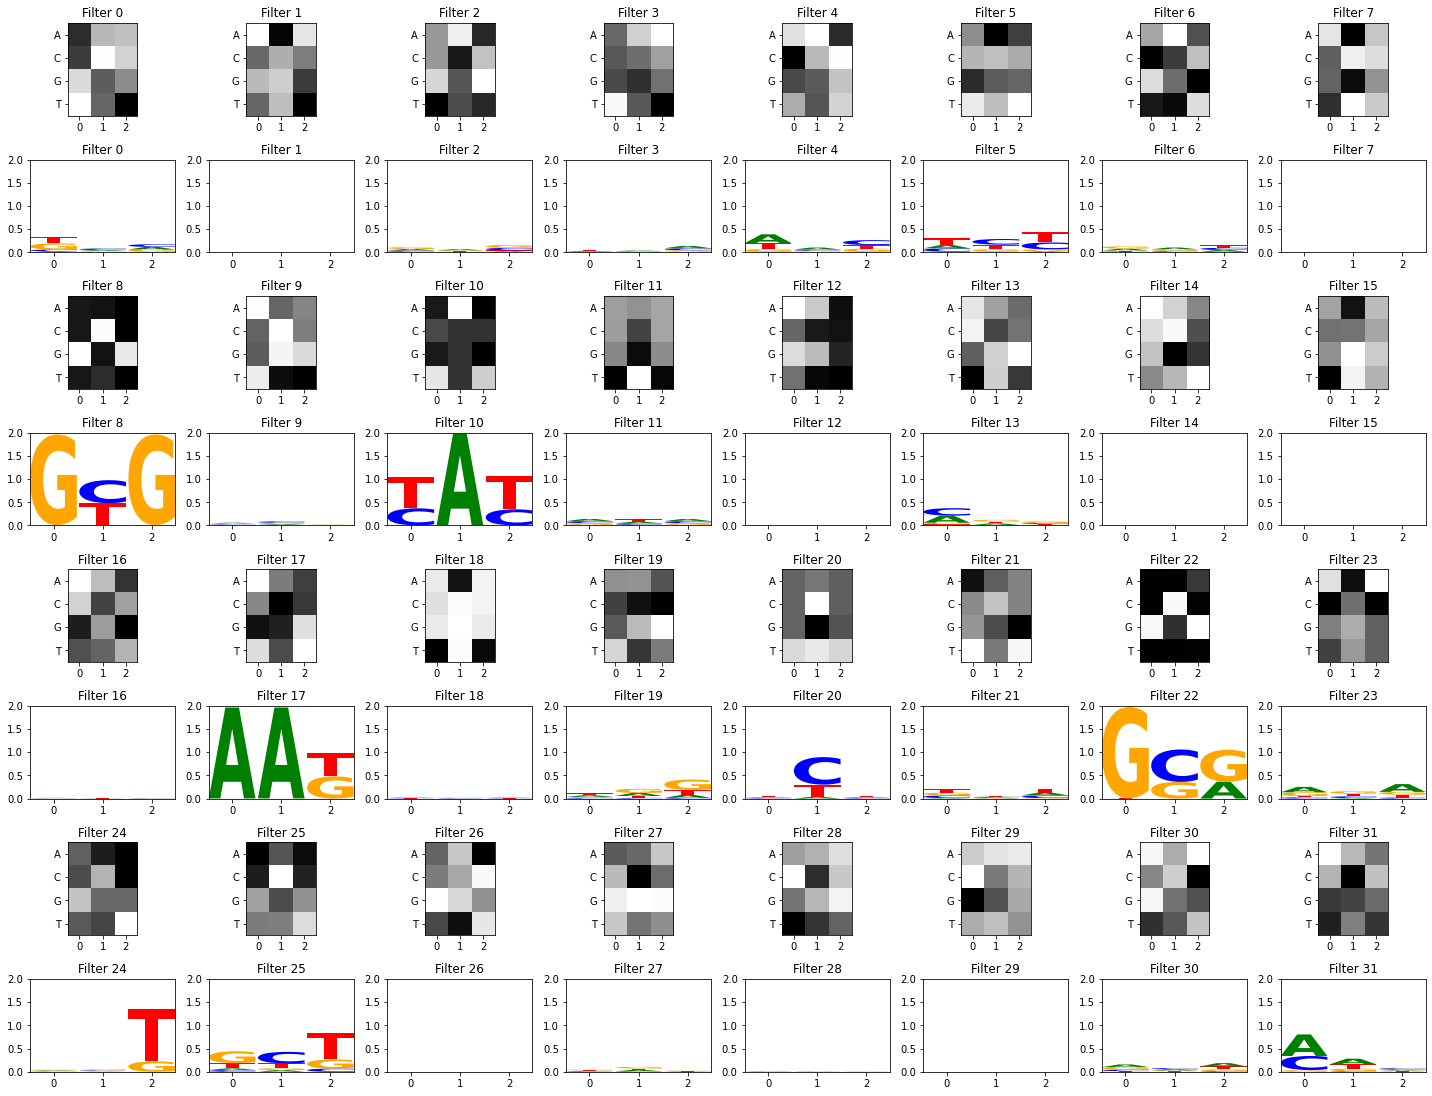

In [60]:
u.view_filters_and_logos(model_weights,filter_activations)

# Try LSTM multi

In [65]:
class DNA_LSTM_Multi(nn.Module):
    def __init__(self,seq_len,hidden_dim=10):
        super().__init__()
        self.seq_len = seq_len

        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
        #self.fc = nn.Linear(hidden_dim, 1)
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(hidden_dim,1)
        self.obj1  = nn.Linear(hidden_dim,1)
        self.obj2  = nn.Linear(hidden_dim,1)
            

    
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

    def forward(self, xb,verbose=False):
        if verbose:
            print("original xb.shape:", xb.shape)
            print(xb) # 11 x 32
        
        # make the one-hot nucleotide vectors group together
        xb = xb.view(-1,self.seq_len,4) 
        if verbose:
            print("re-viewed xb.shape:", xb.shape) # >> 11 x 8 x 4
            print(xb)

        # ** Init hidden/cell states?? **
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
         
        # *******
        
        lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
        if verbose:
            #print("lstm_out",lstm_out)
            print("lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
            print("lstm_out[-1] shape:",lstm_out[-1].shape) # >> 8 x 10
            print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape) # 10

            print("hidden len:",len(self.hidden)) # 2
            print("hidden[0] shape:", self.hidden[0].shape) # >> 1 x 11 x 10
            print("hidden[0][-1] shape:", self.hidden[0][-1].shape) # >> 11 X 10
            print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape) # >> 10

            print("*****")
            # These vectors should be the same, right?
            A = lstm_out[-1][-1]
            B = self.hidden[0][-1][-1]
            print("lstm_out[-1][-1]:",A)
            print("self.hidden[0][-1][-1]",B)
            print("==?", A==B)
            print("*****")
                        
        # attempt to get the last layer from each last position of 
        # all seqs in the batch? IS this the right thing to get?
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        #last_layer = lstm_out[-1][-1].unsqueeze(0) # this was [10X1]? led to FC outoput being [1]?

        out0 = self.obj0(last_layer)
        out1 = self.obj1(last_layer)
        out2 = self.obj2(last_layer)
        
        if verbose:
            print("last layer:", last_layer.shape)
            print("LSTM->FC out shape:",out0.shape)   
                                                
        return out0,out1,out2

Epoch: 0
0 12.030347191127001
Epoch: 1
1 9.072815720322732
Epoch: 2
2 6.305233889394393
Epoch: 3
3 4.896365259782839
Epoch: 4
4 9.923089239122229
Epoch: 5
5 9.090580699718103
Epoch: 6
6 4.492572832296707
Epoch: 7
7 1.6586234103189141
Epoch: 8
8 6.352975162893743
Epoch: 9
9 4.671594671698143


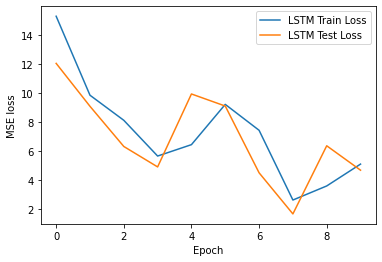

In [66]:
seq_len = len(train_df['seq'][0])
multi_lstm_model = DNA_LSTM_Multi(seq_len)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_lstm_model.parameters(), lr=0.01) 

epochs = 10
train_dl,test_dl = dls['multi_ohe']
train_losses_lstm, val_losses_lstm = fit(epochs, multi_lstm_model, loss_func, optimizer, train_dl, test_dl)

multi_lstm_data_label = list(zip([train_losses_lstm,val_losses_lstm], ['LSTM Train Loss','LSTM Test Loss']))
u.quick_loss_plot(multi_lstm_data_label)